In [44]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from statsmodels.tsa.stattools import coint
from IPython.core import display as ICD
from collections import OrderedDict
from typing import Any, Dict, Iterable, List, Optional, Tuple, Union
array_1d = Union[List, Tuple, pd.Series, np.ndarray]
date_obj = Union[datetime.datetime, datetime.date]
import requests
import bs4 as bs
import functools
from hurst import compute_Hc
import warnings
warnings.filterwarnings('ignore')  # Disable warnings to reduce output spam in notebook

import sys
sys.path.append('../../sif/')
from sif.siftools.backtesters import full_backtesters as fb
from sif.siftools import operators as op
from sif.siftools import metrics as metrics
from sif.sifinfra import sif_utils as su
from sif.siftools.abstractalpha import AbstractAlpha
from sif.sifinsights import alpha_search
from sif.sifinsights.alpha_search import apply_metric_func

In [6]:
# *** GET ROLLING SHARPE RATIO HELPER FUNCTION *** #
def get_rolling_sharpe(returns):
    rolling_sharpe = functools.partial(metrics.rolling_metric, func=metrics.sharpe_ratio, window=252)
    returns.apply(rolling_sharpe).plot()
    plt.title('1 Year Rolling Sharpe Ratio')
    plt.show()

# *** GET OTHER SUMMARY ANALYTICS HELPER FUNCTION *** #
def get_analytics(alphas, returns, holdings):
    perf_tables = apply_metric_func(metrics.generate_performance_table, ('daily_returns', 'holdings'))(returns, holdings)
    for alpha, table in zip(alphas, perf_tables):
        print(f"{alpha.name}")
        ICD.display(table)
        print()

In [45]:
# Send a GET request to the Wikipedia API and return HTML page.
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies') 
# Parse the webpage from Wikipedia with BeautifulSoup.
soup = bs.BeautifulSoup(resp.text, "html.parser") 
table = soup.find('table', {'class': 'wikitable sortable'})
# Store respective information. 
tickers, names, industries = [], [], []
# Iterates through each row in the table excluding the header and extracts relevant data
for row in table.findAll('tr')[1:]:
    tickers.append(row.findAll('td')[0].text)
    names.append(row.findAll('td')[1].text)
    industries.append(row.findAll('td')[3].text)
NUM_INDUSTRIES = len(Counter(industries))
tickers = [s.replace('\n', '') for s in tickers]
stock_info = pd.DataFrame({'Ticker': tickers, 'Name': names, 'Sector': industries}) #Create Dataframe from Wikipedia data
stock_info = stock_info.replace('Communication Services\n','Communication Services') #Clean messy data
stock_info = stock_info.sort_values(by=['Ticker'], ignore_index = True) #Sort Alphabetically by Ticker
display(stock_info.head())
print(f' Number of stocks in stock_info: {stock_info.shape[0]}')

,Ticker,Name,Sector
0,A,Agilent Technologies,Health Care Equipment
1,AAL,American Airlines Group,Passenger Airlines
2,AAP,Advance Auto Parts,Automotive Retail
3,AAPL,Apple Inc.,"Technology Hardware, Storage & Peripherals"
4,ABBV,AbbVie,Pharmaceuticals


 Number of stocks in stock_info: 503


In [12]:
start_date2 = datetime.datetime(2015, 1, 1)
end_date2 = datetime.datetime(2015, 12, 31)
equity_data = su.get_equity_data(tickers=tickers, 
                                 start_date=start_date2, 
                                 end_date=end_date2, 
                                 attributes=['close'])
close_data = equity_data['close']          
close_data.fillna(method='ffill', inplace=True)
close_data.fillna(method='bfill', inplace=True)
close_data = close_data.resample('D').ffill().reset_index()
close_data.set_index('date', inplace=True)
close_data.head()

c:\Users\James Zhang\Desktop\equities-pairs-trading\pairs_v2\../../sif\sif\sifinfra\sif_utils.py:253: DeprecationWarning: execute_query is a deprecated function. sifinfra.sif_utils is a deprecated module and will be removed in a future version of sif. Please remove calls to this module and replace them with alternatives from siftools.data_utils
  cols, response = execute_query(query, params=query_params)


ticker,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,40.56,53.910,158.56,27.332,65.89,90.46,44.90,19.497,88.84,72.34,...,146.89,36.12,92.83,51.93,38.08,72.35,112.59,77.43,28.29,43.31
2015-01-03,40.56,53.910,158.56,27.332,65.89,90.46,44.90,19.497,88.84,72.34,...,146.89,36.12,92.83,51.93,38.08,72.35,112.59,77.43,28.29,43.31
2015-01-04,40.56,53.910,158.56,27.332,65.89,90.46,44.90,19.497,88.84,72.34,...,146.89,36.12,92.83,51.93,38.08,72.35,112.59,77.43,28.29,43.31
2015-01-05,39.80,53.875,156.47,26.562,64.65,89.69,44.91,19.380,87.34,71.98,...,144.39,35.71,90.29,51.57,35.71,70.88,116.79,76.34,27.23,43.05
2015-01-06,39.18,53.040,156.36,26.565,64.33,90.18,44.40,19.423,86.71,70.53,...,141.31,35.90,89.81,50.93,35.50,70.01,115.80,75.79,26.19,42.63


https://www.sciencedirect.com/science/article/pii/S037843712100964X?via%3Dihub

The Hurst Exponent measures long term memory and fractility of a time series. A Brownian random process is given by a hurst exponent of exactly 0.5, while a hurst exponent between 0.5 and 1 indicates a trending behavior, and a hurst exponent between 0 and 0.5 exhibits a mean reverting behavior. This is optimal for a pairs trading strategy. We can use this metric to better trade on trending/momentum strategies with large hurst exponents, or mean reverting strategies like pairs trading with low hurst exponents.

HURST ON STOCKS

482 482
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
Mean: nan
Min: nan
Max: nan
nan
nan
nan
nan
nan
nan
nan


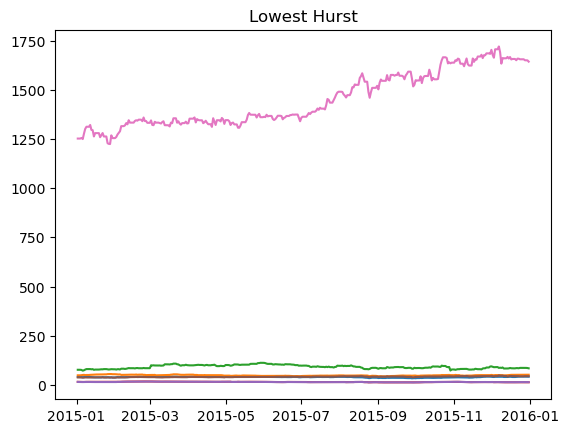

nan
nan
nan
nan
nan
nan
nan


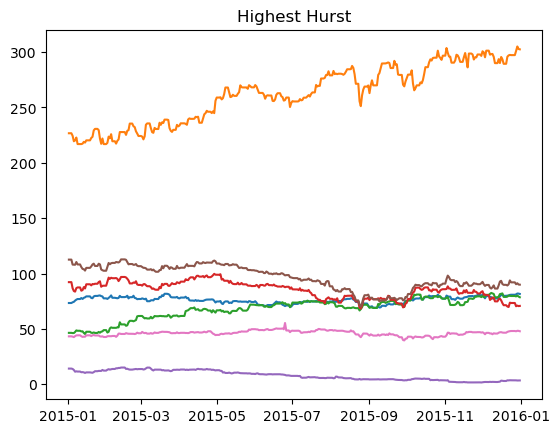

HURST ON PAIRS


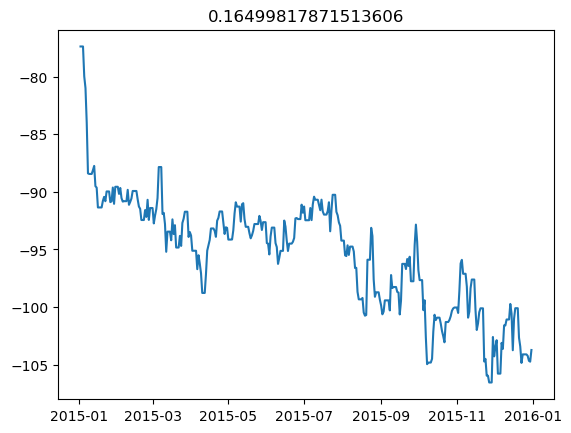

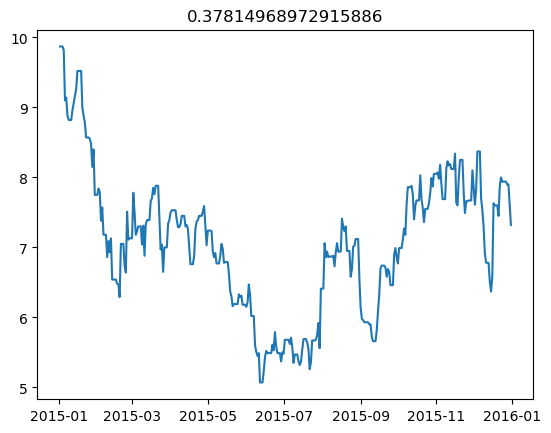

In [22]:
def hurst(p):
    lags = range(2,100)
    variancetau, tau = [], []
    for lag in lags: 
        tau.append(lag) # Write the different lags into a vector to compute a set of tau or lags
        
        # Compute the log returns on all days, then compute the variance on the difference in log returns
        # call this pp or the price difference
        pp = np.subtract(p[lag:], p[:-lag])
        variancetau.append(np.var(pp))

    # we now have a set of tau or lags and a corresponding set of variances.
    # plot the log of those variance against the log of tau and get the slope
    m = np.polyfit(np.log10(tau), np.log10(variancetau), 1)
    hurst = m[0] / 2
    return hurst

print("HURST ON STOCKS\n")
print(len(hurst(close_data)), len(close_data.columns)) # make sure function works properly
h_exp = hurst(close_data)
print(h_exp[:25])
print("Mean:", h_exp.mean())
print("Min:", h_exp.min())
print("Max:", h_exp.max())

indices = np.argsort(h_exp)[:7]
for i in indices:
    plt.plot(close_data.iloc[:, i])
    print(h_exp[i])
plt.title("Lowest Hurst")
plt.show()

indices2 = np.argsort(h_exp)[-7:]
for i in indices2:
    print(h_exp[i])
    plt.plot(close_data.iloc[:, i])
plt.title("Highest Hurst")
plt.show()

print("HURST ON PAIRS")
pair = ("ATVI", "STZ")
pair2 = ("AEE", "XEL")

tspair = close_data["ATVI"] - close_data["STZ"]
tspair2 = close_data["AEE"] - close_data["XEL"]
tspairs = (tspair, tspair2)

for i in tspairs:
    plt.plot(i)
    plt.title((hurst(list(i))))
    plt.show()